# Preparing Features in order to Calculate Safety Score

In order to answer the third research question which is "The survival guide: a personalized guide for eating out safely", we need to prepare a features dataframe that we are going to use to compute the safety score for each establishment*. 

On top of some of the given features (namely 'DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude'), we will calculate the following metrics for each establishment:
- **Violation per Inspection :** the total number of violations over the total number of inspections
- **Critical Violation per Inspection :** the total number of critical violations over the total number of inspections, over the total number of possible critical violations
- **Moderate Violation per Inspection :** the total number of moderate violations over the total number of inspections, over the total number of possible moderate violations
- **Non-Critical Violation per Inspection :** the total number of non-critical violations over the total number of inspections, over the total number of possible non-critical violations
- **Critical Violations Ratio :** ratio of the critical violations count over total violation count
- **Yes Ratio of Allergen :** ratio of the 'Allergen Yes Counts' over the total number of inspections ('Allergen Yes Count' being the total number of inspectior comments which included allergen complaints)
- **Yes Ratio of VomitDiarrheal :** ratio of the 'VomitDiarrheal Yes Counts' over the total number of inspections ('VomitDiarrheal Yes Counts' being the total number of inspectior comments which included poisoning complaints)
- **Yelp Rating :** normalized user rating given for establishment on Yelp.com

*Note that each establishment has a unique DBA Name and a unique address (i.e. we do not consider each DBA Name but rather each tuple made out of DBA Name and address)

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string

import warnings
warnings.filterwarnings("ignore")

## I. Load Main Dataset: Chicago Food Inspection (CFI)

### A. A bit of cleaning

In [2]:
# Read the cleaned dataset
cfi_dataset = pd.read_pickle('datasets/cleaned_inspections.pickle')

In [3]:
# Keep only the restaurants dataset by filtering it in 'Facility Type' column
cfi_selected = cfi_dataset[cfi_dataset['Facility Type'].isin(['Bakery', 'Coffeeshop', 'Drinks Establishment', 
                                                              'Vending', 'Dessert Establishment', 'Restaurant'])]

In [4]:
# Keep only relevent columns
cfi_selected = cfi_selected[['Inspection ID', 'DBA Name', 'License #', 'Address', 'Facility Type', 'Inspection Date', 
                             'Results', 'Latitude', 'Longitude', 'Community Area', 'Violation Numbers', 
                             'Violation Comments']].copy()

We saw the following in Milestone 2 <img src="images/countresult.png" style="height:200px"> 

Hence, we only keep the data with "Pass", "Fail", "Pass w/ Conditions" results.


In [6]:
# Keep only the wanted results from data 
cfi_selected = cfi_selected[cfi_selected['Results'].isin(['Pass', "Fail", "Pass w/ Conditions"])]

In 'DataCleaningAndExploratoryAnalysis.ipynb', we saw that the number of inspections increased over the years. However, in November 2019, we see a big drop. <img src="images/linegraph.png" style="height:400px"> 
We downloaded the dataset at the start of November 2019. Hence, this drop was expected. But in order to avoid any misinterpretations later in the safety score calculation, we will remove all data with inspection date after October 2019 (included).

In [7]:
cfi_selected['Inspection Year'] = [x.year for x in cfi_selected['Inspection Date']]
cfi_selected['Inspection Month'] = [x.month for x in cfi_selected['Inspection Date']]
group_by_inspection_date = cfi_selected.groupby(by=['Inspection Year', 'Inspection Month']).size().reset_index(name="Count")
group_by_inspection_date

,Inspection Year,Inspection Month,Count
0,2010,1,803
1,2010,2,828
2,2010,3,844
3,2010,4,800
4,2010,5,786
...,...,...,...
114,2019,7,883
115,2019,8,951
116,2019,9,702
117,2019,10,760


In [8]:
# Calculate the size of the data before dropping the 2019.11's data.
before_length = len(cfi_selected)

In [9]:
# Create a dataframe where inspection date year is 2019 and inspection date month is 11
cfi_201911 = cfi_selected[(cfi_selected['Inspection Year'] == 2019) & (cfi_selected['Inspection Month'] == 11)]
combined = cfi_selected.append(cfi_201911)
cfi_selected = combined[~combined.index.duplicated(keep=False)].reset_index()

# Calculate the size of the data after dropping the 2019.11's data.
after_length = len(cfi_selected)
print('We successfully removed {} of the inpections data which come from the date of 2019.11.'.format(before_length-after_length))

We successfully removed 77 of the inpections data which come from the date of 2019.11.


In [10]:
# Let's drop unnecessary columns
cfi_selected = cfi_selected.drop(['index', 'Inspection Date', 'Inspection Year', 'Inspection Month'], axis=1)

### B. Creating violation features

We first compute the different ratios that we require for score computation.

In [11]:
# Divide the dataset into two so as to be able to calculate violation counts over the list of violation numbers

# The dataset where the Violation Numbers column is NaN
cfi_selected_nan = cfi_selected[pd.isnull(cfi_selected['Violation Numbers'])]
cfi_selected_nan = cfi_selected_nan.reset_index().drop(columns = 'index')

# The dataset where the Violation Numbers column is not NaN
cfi_selected_filled = cfi_selected[~pd.isnull(cfi_selected['Violation Numbers'])]
cfi_selected_filled = cfi_selected_filled.reset_index().drop(columns = 'index')

In [12]:
print('The length of the dataframe is {} before splitting.'.format(len(cfi_selected)))
print('The length of the dataframe is {} after splitting.'.format(len(cfi_selected_nan)+len(cfi_selected_filled)))

The length of the dataframe is 116709 before splitting.
The length of the dataframe is 116709 after splitting.


In [13]:
# Add a new column for the total number of violation counts
cfi_selected_filled['Violation Counts'] = [len(cfi_selected_filled['Violation Numbers'][i]) for i in range(len(cfi_selected_filled))]

# For NaN values this count is set to 0 since there is no violations reported by the inspectors for those
cfi_selected_nan['Violation Counts'] = 0

In [14]:
# Total number of violation counts according to range of gradings based on the given source below
# source: https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF
'''
Count the violation numbers for each inspection:
Since we have  45 distinct violations (violation numbers 1-44 and 70). 
We used the explanation given in the source: An inspection can pass, pass with conditions or fail. Establishments receiving a ‘pass’ were found to 
have no critical or serious violations (violation number 1-14 and 15-29, respectively).

Hence, we decided to use following mapping:
if there is violation number between 1 and 14 points it will be counted as 'Critical Violations Count'
if there is violation number between 15 and 29 points it will be counted as 'Moderate Violations Count'
if there is violation number between 30 and more points it will be counted as 'Non-Critical Violations Count'
'''

cfi_selected_filled['Critical Violations Count'] = [int(len([ i for i in cfi_selected_filled['Violation Numbers'][k] if i<=14])) for k in range(len(cfi_selected_filled))]
cfi_selected_filled['Moderate Violations Count'] = [int(len([ i for i in cfi_selected_filled['Violation Numbers'][k] if i>=15 and i<=29])) for k in range(len(cfi_selected_filled))]
cfi_selected_filled['Non-Critical Violations Count'] = [int(len([ i for i in cfi_selected_filled['Violation Numbers'][k] if i>=30])) for k in range(len(cfi_selected_filled))]

# For NaN values these counts are set to 0 since there is no violations reported by the inspectors for those
cfi_selected_nan['Critical Violations Count'] = 0
cfi_selected_nan['Moderate Violations Count'] = 0
cfi_selected_nan['Non-Critical Violations Count'] = 0

We examine the "Violation Comments" column, namely to extract whether there were poisoning complaints from the inspector. We use this to create a food poisoning flag, and compute the ratio of outcomes with such complaints over all inspections for each establishment.

In [15]:
# Adding Allergen flag to the dataset
cfi_selected_filled['Allergen Flag'] = np.nan
all_comments = []
for i in range(len(cfi_selected_filled)):
    comment = pd.Series([x.strip() for x in cfi_selected_filled['Violation Comments'][i]])
    all_comments.append(comment) # List of series objects

cfi_selected_filled['temp'] = [(all_comments[i].astype(str).str.contains('ALLERGEN', flags=re.IGNORECASE, regex=True)== True).any() for i in range(len(all_comments))]
cfi_selected_filled['Allergen Flag'] = ['Y' if str(x) == 'True' else 'N' for x in cfi_selected_filled['temp']]
      
# For NaN values dataset this flag is set to 'N' since there is no violation comments for those, we can safely say that there is no issue with them
cfi_selected_nan['Allergen Flag'] = 'N'


In [16]:
# Adding Vomit or Diarrheal Events Flag to the dataset
cfi_selected_filled['Vomit or Diarrheal Flag'] = np.nan
all_comments = []
for i in range(len(cfi_selected_filled)):
    comment = pd.Series([x.strip() for x in cfi_selected_filled['Violation Comments'][i]])
    all_comments.append(comment) # List of series objects
    
cfi_selected_filled['temp_vomit'] = [(all_comments[i].astype(str).str.contains('VOMIT', flags=re.IGNORECASE, regex=True)== True).any() for i in range(len(all_comments))]
cfi_selected_filled['temp_diarrheal'] = [(all_comments[i].astype(str).str.contains('DIARRHEAL', flags=re.IGNORECASE, regex=True)== True).any() for i in range(len(all_comments))]
cfi_selected_filled['temp1'] = (cfi_selected_filled['temp_vomit'] | cfi_selected_filled['temp_diarrheal'])
cfi_selected_filled['Vomit or Diarrheal Flag'] = ['Y' if str(x) == 'True' else 'N' for x in cfi_selected_filled['temp1']]
      
# For NaN values dataset this flag is set to 'N' since there is no violation comments for those, we can safely say that there is no issue with them
cfi_selected_nan['Vomit or Diarrheal Flag'] = 'N'

In [17]:
# Drop unnecessary columns
cfi_selected_filled = cfi_selected_filled.drop(['temp', 'temp_vomit', 'temp_diarrheal', 'temp1'], axis=1).reset_index().drop('index', axis=1)

In [18]:
print('The length of the dataframe is {} before merging.'.format(len(cfi_selected)))

The length of the dataframe is 116709 before merging.


In [19]:
# Let's merge two dataframes that we divided into two above
cfi_selected = pd.concat([cfi_selected_filled, cfi_selected_nan])  

In [20]:
print('The length of the dataframe is {} after merging.'.format(len(cfi_selected)))

The length of the dataframe is 116709 after merging.


We can now safely drop the 'Violation Comments' and the 'Violation Numbers' columns as we have extracted the features we need from them.

In [21]:
cfi_selected = cfi_selected.drop(['Violation Comments', 'Violation Numbers'] ,axis=1).reset_index().drop('index', axis=1)

We now turn our attention to inspection outcomes.

In order to calculate the rate of the failed ('Fail' results) inspections and successful (here we consider successful as combination of 'Pass' and 'Pass w/ Conditions') inspections we do following.

In [22]:
grouped_by_results = cfi_selected[['Inspection ID', 'DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude', 'Results']]\
                                    .groupby(by=['DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude', 'Results'])\
                                    .size().reset_index(name="Count")

In [23]:
# Mapping the 'Pass w/ Conditions' to 'Pass' and keeping all other results as it is
grouped_by_results['Results'] = grouped_by_results['Results'].map({'Pass w/ Conditions': 'Pass', 
                                                                  'Pass': 'Pass',
                                                                  'Fail': 'Fail'})

In [24]:
# Get unique establishments' names, licence number, community areas, latitude and longitude
grouped_dba_names_area = grouped_by_results[['DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude']]\
                                        .drop_duplicates().reset_index().drop('index', axis=1)

In [25]:
def get_sum_results(df):
    '''
    Function to get sum over all 'Pass' results and 'Fail' results separately into two variables
    Arguments:
    df - dataframe to consider
    Returns:
    List l such that:
        l[0] contains the number of passes
        l[1] contains the number of fails
    '''
    df = df.reset_index()
    df = df.drop('index', axis=1)
    succes_sum = sum(df[(df['Results'] == 'Pass')]['Count'])
    fail_sum = sum(df[(df['Results'] == 'Fail')]['Count'])
    return [succes_sum, fail_sum]

In [26]:
# Create a new column named 'Successful Inspection Count' for total number of the pass counts
grouped_dba_names_area['Successful Inspection Count'] = [get_sum_results(grouped_by_results[(grouped_by_results['DBA Name']==grouped_dba_names_area['DBA Name'][i]) & (grouped_by_results['Community Area']==grouped_dba_names_area['Community Area'][i])])[0] for i in range(len(grouped_dba_names_area))]
                                                    

In [27]:
# Create a new column named 'Failed Inspection Count' for total number of the fail counts
grouped_dba_names_area['Failed Inspection Count'] = [get_sum_results(grouped_by_results[(grouped_by_results['DBA Name']==grouped_dba_names_area['DBA Name'][i]) & (grouped_by_results['Community Area']==grouped_dba_names_area['Community Area'][i])])[-1] for i in range(len(grouped_dba_names_area))]
                                                

In order to aggregate the 'Vomit or Diarrheal Flag' feature we follow similar steps.

In [28]:
grouped_by_vomitDiarrheal = cfi_selected[['Inspection ID', 'DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude', 
                                             'Vomit or Diarrheal Flag']]\
                                        .groupby(by=['DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude', 
                                                     'Vomit or Diarrheal Flag'])\
                                        .size().reset_index(name="Count")

In [29]:
def get_count_VomitDiarrheal(df):
    '''
    Function to get sum over all 'Yes' and 'No' Vomit or Diarrheal Flag separately into two variables
    Arguments:
    df - dataframe to consider
    Returns:
    List l such that:
        l[0] contains the number of poisoning complaints
        l[1] contains the number of inspection outcomes with no poisoning complaints
    '''
    df = df.reset_index()
    df = df.drop('index', axis=1)
    yes_count = sum(df[(df['Vomit or Diarrheal Flag'] == 'Y')]['Count'])
    no_count = sum(df[(df['Vomit or Diarrheal Flag'] == 'N')]['Count'])
    return [yes_count, no_count]

In [30]:
# Create a new column named 'VomitDiarrheal Yes Counts' for total number of the yes counts
grouped_dba_names_area['VomitDiarrheal Yes Counts'] = [get_count_VomitDiarrheal(grouped_by_vomitDiarrheal[(grouped_by_vomitDiarrheal['DBA Name']==grouped_dba_names_area['DBA Name'][i]) & (grouped_by_vomitDiarrheal['Community Area']==grouped_dba_names_area['Community Area'][i])])[0] for i in range(len(grouped_dba_names_area))]
  

In [31]:
# Create a new column named 'VomitDiarrheal No Counts' for total number of the no counts
grouped_dba_names_area['VomitDiarrheal No Counts'] = [get_count_VomitDiarrheal(grouped_by_vomitDiarrheal[(grouped_by_vomitDiarrheal['DBA Name']==grouped_dba_names_area['DBA Name'][i]) & (grouped_by_vomitDiarrheal['Community Area']==grouped_dba_names_area['Community Area'][i])])[-1] for i in range(len(grouped_dba_names_area))]
  

In order to aggregate the 'Allergen Flag' feature we follow similar steps.

In [32]:
grouped_by_allergen = cfi_selected[['Inspection ID', 'DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude', 'Allergen Flag']]\
                                    .groupby(by=['DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude', 'Allergen Flag'])\
                                    .size().reset_index(name="Count")

In [33]:
def get_count_allergen(df):
    '''
    Function to get sum over all 'Yes' and 'No' allergen Flag separately into two variables
    Arguments:
    df - dataframe to consider
    Returns:
    List l such that:
        l[0] contains the number of allergen complaints
        l[1] contains the number of inspection outcomes with no allergen complaints
    '''
    df = df.reset_index()
    df = df.drop('index', axis=1)
    yes_count = sum(df[(df['Allergen Flag'] == 'Y')]['Count'])
    no_count = sum(df[(df['Allergen Flag'] == 'N')]['Count'])
    return [yes_count, no_count]

In [34]:
# Create a new column named 'Allergen Yes Counts' for total number of the yes counts
grouped_dba_names_area['Allergen Yes Counts'] = [get_count_allergen(grouped_by_allergen[(grouped_by_allergen['DBA Name']==grouped_dba_names_area['DBA Name'][i]) & (grouped_by_allergen['Community Area']==grouped_dba_names_area['Community Area'][i])])[0] for i in range(len(grouped_dba_names_area))]
  

In [35]:
# Create a new column named 'N VomitDiarrheal Counts' for total number of the no counts
grouped_dba_names_area['Allergen No Counts'] = [get_count_allergen(grouped_by_allergen[(grouped_by_allergen['DBA Name']==grouped_dba_names_area['DBA Name'][i]) & (grouped_by_allergen['Community Area']==grouped_dba_names_area['Community Area'][i])])[-1] for i in range(len(grouped_dba_names_area))]
  

We now aggregate the violation count.

In [36]:
grouped_violations_sum = cfi_selected.groupby(by=['DBA Name', 'Address', 'Community Area', 'Facility Type', 'Latitude', 'Longitude'])\
                                                .agg({'Violation Counts': 'sum',
                                                      'Critical Violations Count': 'sum',
                                                      'Moderate Violations Count': 'sum',
                                                      'Non-Critical Violations Count': 'sum',
                                                      }).reset_index()

In [37]:
# Merge two datasets that we aggregated above: grouped_violations_sum and grouped_dba_names_area
features_dataframe = grouped_violations_sum.merge(grouped_dba_names_area)

In [38]:
# Normalization:
# Add columns for total counts and rate of counts and flags to use in further analysis in the score calculation
features_dataframe['Total Inspections Result Counts']  = (features_dataframe['Successful Inspection Count'] + features_dataframe['Failed Inspection Count'])
features_dataframe['Total VomitDiarrheal Flag Counts'] = (features_dataframe['VomitDiarrheal Yes Counts'] + features_dataframe['VomitDiarrheal No Counts'])
features_dataframe['Total Allergen Flag Counts']       = (features_dataframe['Allergen Yes Counts'] + features_dataframe['Allergen No Counts'])

features_dataframe['Violation per Inspection']              = (features_dataframe['Violation Counts'] / (features_dataframe['Total Inspections Result Counts']*45)) # 45 is the total possible violation numbers that one establishment can have
features_dataframe['Critical Violation per Inspection']     = (features_dataframe['Critical Violations Count'] / (features_dataframe['Total Inspections Result Counts']*14)) # 14 is the total possible critical violation numbers that one establishment can have
features_dataframe['Moderate Violation per Inspection']     = (features_dataframe['Moderate Violations Count'] / (features_dataframe['Total Inspections Result Counts']*15)) # 15 is the total possible moderate violation numbers that one establishment can have
features_dataframe['Non-Critical Violation per Inspection'] = (features_dataframe['Non-Critical Violations Count'] / (features_dataframe['Total Inspections Result Counts']*16)) # 16 is the total possible non-critical violation numbers that one establishment can have

features_dataframe['Success Ratio of Inspections'] = (features_dataframe['Successful Inspection Count'] / features_dataframe['Total Inspections Result Counts'])
features_dataframe['Failure Ratio of Inspections'] = (features_dataframe['Failed Inspection Count'] / features_dataframe['Total Inspections Result Counts'])
features_dataframe['Yes Ratio of VomitDiarrheal']  = (features_dataframe['VomitDiarrheal Yes Counts'] / features_dataframe['Total VomitDiarrheal Flag Counts'])
features_dataframe['No Ratio of VomitDiarrheal']   = (features_dataframe['VomitDiarrheal No Counts'] / features_dataframe['Total VomitDiarrheal Flag Counts'])
features_dataframe['Yes Ratio of Allergen']        = (features_dataframe['Allergen Yes Counts'] / features_dataframe['Total Allergen Flag Counts'])
features_dataframe['No Ratio of Allergen']         = (features_dataframe['Allergen No Counts'] / features_dataframe['Total Allergen Flag Counts'])

features_dataframe['Critical Violations Ratio']     = (features_dataframe['Critical Violations Count'] / features_dataframe['Violation Counts'])
features_dataframe['Moderate Violations Ratio']     = (features_dataframe['Moderate Violations Count'] / features_dataframe['Violation Counts'])
features_dataframe['Non-Critical Violations Ratio'] = (features_dataframe['Non-Critical Violations Count'] / features_dataframe['Violation Counts'])


In [39]:
# Check whether there are NaN values in the dataset
features_dataframe.isna().sum()

DBA Name                                    0
Address                                     0
Community Area                              0
Facility Type                               0
Latitude                                    0
Longitude                                   0
Violation Counts                            0
Critical Violations Count                   0
Moderate Violations Count                   0
Non-Critical Violations Count               0
Successful Inspection Count                 0
Failed Inspection Count                     0
VomitDiarrheal Yes Counts                   0
VomitDiarrheal No Counts                    0
Allergen Yes Counts                         0
Allergen No Counts                          0
Total Inspections Result Counts             0
Total VomitDiarrheal Flag Counts            0
Total Allergen Flag Counts                  0
Violation per Inspection                    0
Critical Violation per Inspection           0
Moderate Violation per Inspection 

Some establishment did not have violations in any of their inspections. Hence, they get NaN's for the "Critical Violations Ratio", "Moderate Violations Ratio", and "Non-Critical Violations Ratio" columns. Hence, we can safely replace these values with $0$.

In [40]:
# Fillna values with 0; cause this NaN is resulted from violations count column which is 0 for each of them
features_dataframe['Critical Violations Ratio'].fillna(0, inplace=True)    
features_dataframe['Moderate Violations Ratio'].fillna(0, inplace=True)    
features_dataframe['Non-Critical Violations Ratio'].fillna(0, inplace=True)

In [41]:
features_dataframe.describe()

,Latitude,Longitude,Violation Counts,Critical Violations Count,Moderate Violations Count,Non-Critical Violations Count,Successful Inspection Count,Failed Inspection Count,VomitDiarrheal Yes Counts,VomitDiarrheal No Counts,...,Non-Critical Violation per Inspection,Success Ratio of Inspections,Failure Ratio of Inspections,Yes Ratio of VomitDiarrheal,No Ratio of VomitDiarrheal,Yes Ratio of Allergen,No Ratio of Allergen,Critical Violations Ratio,Moderate Violations Ratio,Non-Critical Violations Ratio
count,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,...,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000,16788.000000
mean,41.888070,-87.674171,22.475399,2.209971,2.142781,18.122647,7.516679,1.850608,0.456159,8.911127,...,0.148044,0.791373,0.208627,0.046603,0.953397,0.031163,0.968837,0.084222,0.085868,0.738714
std,0.074302,0.054322,22.926222,3.084065,2.704448,18.615376,14.586904,2.755795,1.028594,16.215964,...,0.102496,0.203210,0.203210,0.119564,0.119564,0.097582,0.097582,0.115824,0.104550,0.278550
min,41.644670,-87.914428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.853993,-87.703192,6.000000,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,2.000000,...,0.076389,0.666667,0.000000,0.000000,0.963964,0.000000,1.000000,0.000000,0.000000,0.694444
50%,41.895615,-87.663963,15.000000,1.000000,1.000000,12.000000,4.000000,1.000000,0.000000,5.000000,...,0.140625,0.818182,0.181818,0.000000,1.000000,0.000000,1.000000,0.054201,0.066667,0.812500
75%,41.939721,-87.634848,33.000000,3.000000,3.000000,26.000000,9.000000,2.000000,1.000000,11.000000,...,0.206250,1.000000,0.333333,0.036036,1.000000,0.000000,1.000000,0.130435,0.128205,0.909091
max,42.020808,-87.526940,393.000000,42.000000,35.000000,321.000000,220.000000,35.000000,12.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# Save to pickle
features_dataframe.to_pickle('pickles/features_dataframe')

## II. Secondary Datasets 

### A. Chains

We would like to have the information about if the given facility is in a chain or not. In order to find that, we use a secondary dataset to get the chain establishment names.

In [2]:
# Load fast food restaurants dataset and saved features from the Part I
fast_foods = pd.read_csv('datasets/FastFoodRestaurants.csv')
features_dataframe = pd.read_pickle('pickles/features_dataframe')

In [3]:
# We only keep the restaurants that appear more than once
chain_counts = (fast_foods['name'].value_counts())
fast_food_chains = chain_counts[chain_counts.values>1].index.tolist()

In [4]:
print('There are {} chains in the secondary dataset which is called "FastFoodRestaurants.csv".'.format(len(fast_food_chains)))

There are 173 chains in the secondary dataset which is called "FastFoodRestaurants.csv".


These 173 chain names do not cover all chain establishments in our dataset. Hence, we chose to set a chain flag and set it to 'Y' every time an establishments appears more than twice in our dataset. We do this by checking if an establishment has more than one address (using the latitude and longitude).

In [5]:
additional_chains = features_dataframe[['DBA Name', 'Address', 'Latitude', 'Longitude']].drop_duplicates().reset_index().drop('index', axis=1)
grouped_by_dbaname = additional_chains.groupby(by=['DBA Name']).size().reset_index(name="Count")
establishments_repeted = grouped_by_dbaname[grouped_by_dbaname['Count']>1].reset_index()
other_fast_food_chains = set(establishments_repeted['DBA Name'])

In [6]:
print('There are {} establishments which have more than one location can be seen as chains.'.format(len(other_fast_food_chains)))

There are 972 establishments which have more than one location can be seen as chains.


Let's add those unique establishment names to our secondary chains dataset.

In [7]:
# Extend the set of chain establishments in the dataset
fast_food_chains.extend(other_fast_food_chains)
fast_food_chains = set(fast_food_chains)

In [8]:
print('After extending the set of chains, we have {} food chains in total.'.format(len(fast_food_chains)))

After extending the set of chains, we have 1136 food chains in total.


In [9]:
# We remove the char '\'' for simplicity, transform everything to lowercase and remove duplicates
fast_food_chains = set([chain_name.replace("\'", "").lower() for chain_name in fast_food_chains])

In [10]:
print('After normalizing the set of chains, we have {} unique food chains names in total.'.format(len(fast_food_chains)))

After normalizing the set of chains, we have 1048 unique food chains names in total.


We now add the flag to our dataset.

In [11]:
# We create a new column "Chain flag" for food chains
# We fill the column with 'N' for No' and 'Y' for 'Yes' if the establishment name exists (or not exist) in the fast_food_chains
boolean_foodchains = pd.DataFrame(features_dataframe['DBA Name'].str.replace("\'", "")\
                                  .str.lower().isin(fast_food_chains)).rename(columns={"DBA Name": "Chain flag temp"})

In [12]:
# Add the boolean_foodchains['Chain flag temp'] columns to the main dataset CFI as a new column: 'Chain flag'
features_dataframe['Chain flag'] = boolean_foodchains['Chain flag temp']

### B. Yelp

We would like to use the Yelp dataset to see whether the rating information (for the establishments) given by Yelp users can be used in the safety score calculation.

In [13]:
# Read yelp dataset
yelp_dataset = pd.read_pickle('pickles/business_details.pickle')

We will fetch out the establishment ratings given by Yelp users.

In [14]:
# Keep only the fetaures that we need
yelp_dataset = yelp_dataset[['name', 'location.address1', 'rating']]
yelp_dataset['Lowercased Address'] = yelp_dataset['location.address1'].str.lower()
yelp_dataset['Lowercased Name'] = yelp_dataset['name'].str.lower()
yelp_dataset = yelp_dataset.drop(['location.address1', 'name'], axis=1)
yelp_dataset = yelp_dataset.drop_duplicates()
yelp_dataset = yelp_dataset[['Lowercased Name', 'Lowercased Address', 'rating']]
yelp_dataset.head()

,Lowercased Name,Lowercased Address,rating
0,carniceria y fruteria los altos,2959 w 40th st,3.5
1,al's beef,234 s wabash ave,3.0
2,peking mandarin,3459 w lawrence ave,4.0
3,la humita,3466 n pulaski rd,4.0
4,chicago produce,3500 w lawrence ave,3.5


In [15]:
# Check if there NaN values in the dataset
yelp_dataset.isna().sum()

Lowercased Name       1
Lowercased Address    1
rating                1
dtype: int64

We drop the rows where all the columns coming from the Yelp dataset are NaN.

In [16]:
yelp_dataset = yelp_dataset.dropna(how='all').reset_index().drop(['index'], axis = 1) 

In [17]:
yelp_dataset.describe()

,rating
count,14284.000000
mean,3.537314
std,0.905850
min,1.000000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


#### Examine the rating column

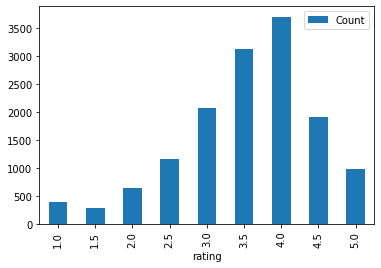

In [18]:
# Distribution of ratings in the yelp dataset
rating_distribution = yelp_dataset.groupby(by=['rating']).size().reset_index(name="Count").set_index('rating')
rating_distribution.plot(kind="bar", y='Count')
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [19]:
# Aggregate the Yelp dataset to have the Price and rating for each restaurant 
yelp_dataset_grouped = yelp_dataset[['Lowercased Name', 'Lowercased Address', 'rating']].groupby(by=['Lowercased Name', 'Lowercased Address'])\
                                   .agg({'rating':'mean'}).reset_index()
yelp_dataset_grouped.head()

,Lowercased Name,Lowercased Address,rating
0,!hello tacos!,816 w randolph st,3.5
1,1 chop suey,7342 s stony island ave,2.5
2,1000 liquors,1000 w belmont ave,2.5
3,101 n wacker dr,101 n wacker dr,4.0
4,1048 sky lounge - wrigley rooftop,1048 waveland ave,3.0


In [20]:
# Normalizing the name and address columns in order to merge correctly
features_dataframe['Lowercased Name'] = features_dataframe['DBA Name'].str.lower()
features_dataframe['Lowercased Address'] = features_dataframe['Address'].str.lower()

features_dataframe['Lowercased Name'] = features_dataframe['Lowercased Name'].astype(str).str.strip()
features_dataframe['Lowercased Address'] = features_dataframe['Lowercased Address'].astype(str).str.strip()

features_dataframe['Lowercased Name'] = [features_dataframe['Lowercased Name'][i].translate(str.maketrans('', '', string.punctuation))\
                                         .replace(" ", "") for i in (range(len(features_dataframe)))]

yelp_dataset_grouped['Lowercased Name'] = [yelp_dataset_grouped['Lowercased Name'][i].translate(str.maketrans('', '', string.punctuation))\
                                           .replace(" ", "") for i in (range(len(yelp_dataset_grouped)))]

In [21]:
# Merge features_dataframe with yelp_dataset_grouped in order to get the rating scores for each restaurant locations:
features_df = features_dataframe.merge(yelp_dataset_grouped, 
                                       how='left', 
                                       left_on=['Lowercased Name', 'Lowercased Address'],
                                       right_on=['Lowercased Name', 'Lowercased Address'])

In [22]:
# Check if there are still NaN values in the dataset
features_df.isna().sum()

DBA Name                                     0
Address                                      0
Community Area                               0
Facility Type                                0
Latitude                                     0
Longitude                                    0
Violation Counts                             0
Critical Violations Count                    0
Moderate Violations Count                    0
Non-Critical Violations Count                0
Successful Inspection Count                  0
Failed Inspection Count                      0
VomitDiarrheal Yes Counts                    0
VomitDiarrheal No Counts                     0
Allergen Yes Counts                          0
Allergen No Counts                           0
Total Inspections Result Counts              0
Total VomitDiarrheal Flag Counts             0
Total Allergen Flag Counts                   0
Violation per Inspection                     0
Critical Violation per Inspection            0
Moderate Viol

We see that there are 12788 NaN values for the rating column in the dataset. Let's see if we can find more information about them. In particular, we can try to find other branches for the establishments with missing ratings and use these ratings to calculate an average rating.

In [23]:
# Create a feature dataframe subset
features_df_subset = features_df[['Lowercased Name', 'Lowercased Address', 'rating']]\
                                     .groupby(by=['Lowercased Name', 'Lowercased Address'])\
                                     .agg({'rating':'mean'})\
                                     .reset_index()\
                                     .sort_values(by=['Lowercased Name'])

In [24]:
# Create s subset of the dataframe where there is no NaN value in the rating column
features_df_no_nan_ratings = features_df_subset[(pd.notna(features_df_subset['rating']))].drop_duplicates().reset_index().drop(['index'],axis=1)
# Group by Lowercase and rating to be able to calculate the weighted average ratings
grouped_by_name = features_df_no_nan_ratings.groupby(by=['Lowercased Name', 'rating']).size().reset_index(name="Count")
# Create a new column that is simply a product of rating and the number of restaurant names
grouped_by_name['product'] = grouped_by_name['rating']*grouped_by_name['Count']
grouped_by_name = grouped_by_name.groupby(by=['Lowercased Name'])\
                                        .agg({'product': 'sum',
                                              'Count':'sum'}).reset_index()
# Create a new column which shows the weighted average ratings of each restaurants
grouped_by_name['weighted_average_rating'] = round(grouped_by_name['product']/grouped_by_name['Count'],2)
grouped_by_name

,Lowercased Name,product,Count,weighted_average_rating
0,10pinbowlinglounge,3.5,1,3.50
1,11degreesnorth,4.5,1,4.50
2,14parish,4.5,1,4.50
3,1914club,4.5,1,4.50
4,1stchopsuey,3.5,1,3.50
...,...,...,...,...
3311,zenwinespirits,4.5,1,4.50
3312,ziggyssidedoorpubdeli,5.0,1,5.00
3313,zocalo,3.5,1,3.50
3314,zokusushi,3.5,1,3.50


In [25]:
# Feature dataframes where the rating column is NaN and not NaN
features_df_nans = features_df[features_df['rating'].isnull()].reset_index().drop('index', axis=1)
features_df_filled = features_df[~pd.isnull(features_df['rating'])]

In [26]:
# Merge with the dataset that we have the weighted average rating information in it
merged_features_df_nans = features_df_nans.merge(grouped_by_name[['Lowercased Name', 'weighted_average_rating']], 
                                                 how='left', 
                                                 left_on=['Lowercased Name'],
                                                 right_on=['Lowercased Name'])

In [27]:
# Check if there are still NaN values for the rating information
merged_features_df_nans.isna().sum()

DBA Name                                     0
Address                                      0
Community Area                               0
Facility Type                                0
Latitude                                     0
Longitude                                    0
Violation Counts                             0
Critical Violations Count                    0
Moderate Violations Count                    0
Non-Critical Violations Count                0
Successful Inspection Count                  0
Failed Inspection Count                      0
VomitDiarrheal Yes Counts                    0
VomitDiarrheal No Counts                     0
Allergen Yes Counts                          0
Allergen No Counts                           0
Total Inspections Result Counts              0
Total VomitDiarrheal Flag Counts             0
Total Allergen Flag Counts                   0
Violation per Inspection                     0
Critical Violation per Inspection            0
Moderate Viol

In [28]:
print('The precentage of the NaN ratings in the yelp dataset over the feature dataset after recovering from the weighted average rating scores is: {}%.'.format(round(100*len(merged_features_df_nans[pd.isna(merged_features_df_nans['weighted_average_rating'])])/len(features_df),2)))
                                                                                                      

The precentage of the NaN ratings in the yelp dataset over the feature dataset after recovering from the weighted average rating scores is: 69.19%.


We can see that the Yelp dataset does not give us ratings for all the establishments that we have in our main dataset. Roughly 69% of our establishments have no rating information. However, we will keep the rating information from Yelp dataset for safety score calculation, because it could be interesting to see the score results with including Yelp user ratings. Let's finalize to gather all the information into a single dataframe.

In [29]:
# Create a new column for beign able to do merge
features_df_filled['weighted_average_rating'] = np.nan

In [30]:
# Merge 
features_df = pd.concat([features_df_filled, merged_features_df_nans]).reset_index().drop('index', axis=1)

In [31]:
# Fill NaN values with 0 for ratings
features_df['weighted_average_rating'].fillna(0, inplace=True)
features_df['rating'].fillna(0, inplace=True)

In [32]:
# Create a new column 'Yelp Rating'
features_df['Yelp Rating'] = [(max(features_df['rating'][i], features_df['weighted_average_rating'][i])/5) for i in range(len(features_df))] # We divide by 5 to normalize


In [33]:
features_for_score = features_df[['DBA Name','Address','Community Area', 'Facility Type', 'Latitude', 'Longitude',
                                  'Violation per Inspection', 'Critical Violation per Inspection', 
                                  'Moderate Violation per Inspection', 'Non-Critical Violation per Inspection',  
                                  'Critical Violations Ratio', 'Yes Ratio of VomitDiarrheal', 'Yes Ratio of Allergen',
                                  'Yelp Rating']]

In [34]:
# Save final features to pickle
features_for_score.to_pickle('pickles/features_for_score')